# Estimating Parameters in Network Models via Spectral Methods


Next up, you might think intuitively we would jump to the a posteriori Stochastic Block Model, but as we will see in a second, estimation for an a posteriori Stochastic Block Model is, in fact, additional steps on top of how we estimate parameters for an *a priori* Random Dot Product Graph (RDPG). 

## Why don't we just use MLE?*

The a posteriori Stochastic Block Model has a pair of parameters, the block matrix, $B$, and the community probability vector, $\vec \pi$. If you are keeping up with the log-likelihood derivations in the single network models section, you will recall that the log-likelihood for an a posteriori Stochastic Block Model, we obtain that:

\begin{align*}
    \mathbb P_\theta(A) &= \sum_{\vec \tau \in \mathcal T} \prod_{k = 1}^K \left[\pi_k^{n_k}\cdot \prod_{k'=1}^K b_{k' k}^{m_{k' k}}(1 - b_{k' k})^{n_{k' k} - m_{k' k}}\right]
\end{align*}

That expression, it turns out, is a lot more complicated than what we had to deal with for the *a priori* Stochastic Block Model. Taking the log gives us that:

\begin{align*}
\log 
    \mathbb P_\theta(A) &= \log\left(\sum_{\vec \tau \in \mathcal T} \prod_{k = 1}^K \left[\pi_k^{n_k}\cdot \prod_{k'=1}^K b_{k' k}^{m_{k' k}}(1 - b_{k' k})^{n_{k' k} - m_{k' k}}\right]\right)
\end{align*}

Whereas the log of a product of terms is the sum of the logs of the terms, no such easy simplification exists for the log of a *sum* of terms. This means that we will have to get a bit creative here. Instead, we will turn first to the *a priori* Random Dot Product Graph, and then figure out how to estimate parameters from a *a posteriori* SBM using that.

## *a priori* Random Dot Product Graph

The *a priori* Random Dot Product Graph has a single parameter, $X \in \mathbb R^{n \times d}$, which is a real matrix with $n$ rows (one for each node) and $d$ columns (one for each latent dimension). We estimate $X$ extremely simply for a realization $A$ of a random network $\pmb A$ which is characterized using the *a priori* Random Dot Product Graph.

In order to produce an estimate of $X$, we also need to know the number of latent dimensions of $\pmb A$, $d$. We might have a reasonable ability to "guess" what $d$ is ahead of time, but this will often not be the case. For this reason, we can instead estimate $d$ using $\hat d$ [cite ZG2]. $\hat d$ represents an estimate of $d$, which is selected on the basis of "elbow picking", as described in the section on spectral embedding. The $\hat$ symbol just means that $\hat d$ is an estimate of the number of latent dimensions $d$, and not necessarily the *actual* number of latent dimensions. The estimate of $X$ is produced by using the [Adjacency Spectral Embedding](link?), by embedding the observed network $A$ into $d$ (if the number of latent dimensions is known) or $\hat d$ (if the number of latent dimensions is not known) dimensions.

Let's try an example of an *a priori* RDPG. We will use the same example that we used in the single network models section, where we defined the latent position matrix $X$ as follows. Let's assume that we have $60$ people who live along a very long road that is $20$ miles long, and each person is $\frac{1}{3}$ of a mile apart. The nodes of our network represent the people who live along our assumed street. If two people are closer to one another, it might make sense to think that they have a higher probability of being friends. If two people are neighbors, we think that they will have a very high probability of being friends (almost $1$) and when people are very far apart, we think that they will have a very low probability of being friends (almost $0$). We define $X$ to have rows given by:
\begin{align*}
    \vec x_i = \begin{bmatrix}
        \left(\frac{60 - i}{60}\right)^2 \\
        \left(\frac{i}{60}\right)^2
    \end{bmatrix}
\end{align*}
In this case, since each $\vec x_i$ is $2$-dimensional, the number of latent dimensions in $X$ is $d=2$. Let's simulate an example network:

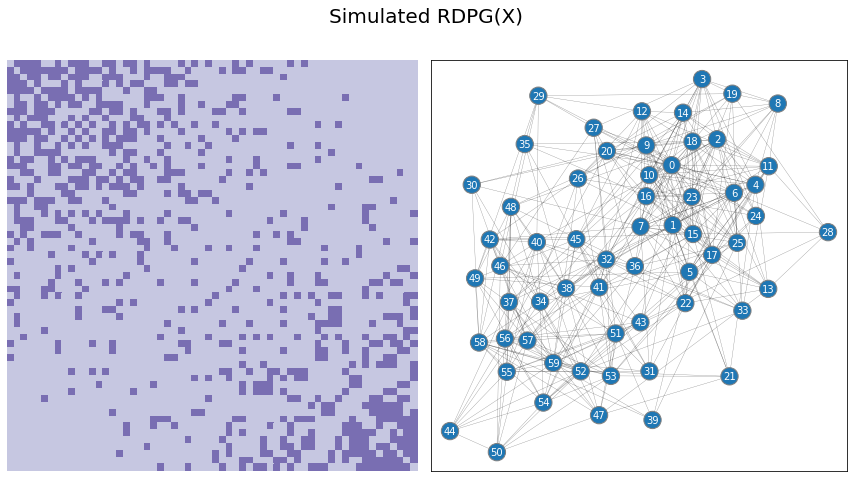

In [72]:
import numpy as np
from graspologic.simulations import rdpg
from graphbook_code import draw_multiplot
from graspologic.plot import heatmap
import matplotlib.pyplot as plt

n = 60  # the number of nodes in our network

# design the latent position matrix X according to 
# the rules we laid out previously
X = np.zeros((n,2))
for i in range(0, n):
    X[i,:] = [((n - i)/n)**2, (i/n)**2]

P = X @ np.transpose(X)

np.random.seed(12)
A = rdpg(X)

draw_multiplot(A, title="Simulated RDPG(X)");

What happens when we fit a `rdpg` model to $A$? We will evaluate the performance of the RDPG estimator agaigraspologic.plot the estimated probability matrix, $\hat P = \hat X \hat X^\top$, to the true probability matrix, $P = XX^\top$. We can do this using the `RDPGEstimator` object, provided directly by graspologic:

In [73]:
from graspologic.models import RDPGEstimator

model = RDPGEstimator(n_components=2, loops=False)  # number of latent dimensions is 2
model.fit(A)
Xhat = model.latent_
Phat = Xhat @ np.transpose(Xhat)

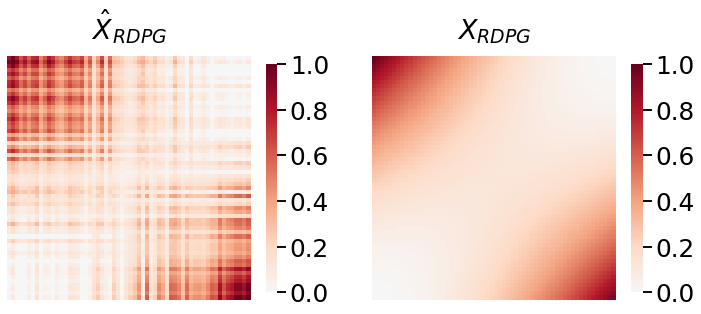

In [74]:
from graphbook_code import plot_latents

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

heatmap(Phat,
        vmin=0,
        vmax=1,
        font_scale=1.5,
        title="$\hat X_{RDPG}$",
        ax=axs[0])

heatmap(P,
        vmin=0,
        vmax=1,
        font_scale=1.5,
        title="$X_{RDPG}$",
        ax=axs[1])

fig;

Note that our estimated probability matrix tends to preserve the pattern in the true probability matrix, where the probabilities are highest for pairs of nodes which are closer together, but lower for pairs of nodes which are farther apart. 

What if we did not know that $d$ was $2$ ahead of time? The RDPG Estimator handles this situation just as well, and we can estimate the number of latent dimensions with $\hat d$ instead:

In [75]:
model = RDPGEstimator(loops=False)  # number of latent dimensions is not known
model.fit(A)
Phat = model.p_mat_
print("Fit number of latent dimensions: {}".format(model.latent_.shape[1]))

Fit number of latent dimensions: 3


So we can see that choosing the best-fit elbow instead yielded $\hat d = 3$; that is, the number of latent dimensions are estimated to be $3$. Again, looking at the estimated and true probability matrices:

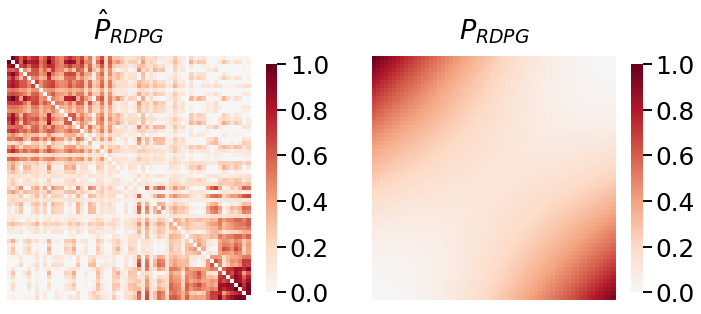

In [76]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

heatmap(Phat,
        vmin=0,
        vmax=1,
        font_scale=1.5,
        title="$\hat P_{RDPG}$",
        ax=axs[0])

heatmap(P,
        vmin=0,
        vmax=1,
        font_scale=1.5,
        title="$P_{RDPG}$",
        ax=axs[1])

fig;

Which also is a decent estimate of the true probability matrix $P$.

## *a posteriori* Stochastic Block Model

Finally, we can return to our original goal, which was to estimate the parameters of an *a posteriori* Stochastic Block Model.

For the *a posteriori* Stochastic Block Model with $K$-communities, recall that we have two parameters, $\vec \pi$ which is a $K$-dimensional probability vector, and $B$ which is the $K \times K$ block matrix. We observe the network $A$, which is a realization of the random network $\pmb A$. To estimate $\vec \pi$ and $B$, the approach we will take will be to use $A$ to produce a *best guess* as to which community each node of $A$ is from, and then use our *best guesses* as to which community each node is from to learn about $\vec \pi$ and $B$.

### Number of communities $K$ is known

When the number of communities is known, the procedure for fitting an *a posteriori* Stochastic Block Model to a network is relatively straightforward. Let's consider a similar example to the scenario we had above, but with $3$ communities instead of $2$. We will have a block matrix given by:
\begin{align*}
    B &= \begin{bmatrix}
        0.8 & 0.2 & 0.2 \\
        0.2 & 0.8 & 0.2 \\
        0.2 & 0.2 & 0.8
    \end{bmatrix}
\end{align*}
Which is a Stochastic block model in which the within-community edge probability is $0.8$, and exceeds the between-community edge probability of $0.2$. We will let the probability of each node being assigned to different blocks be equal, and we will produce a matrix with $100$ nodes in total. For simulating from the Stochastic Block Model, we actually only need the number of nodes for each community, since none of the mathematical operations we take to learn about $\vec \pi$ and $B$ will produce a different answer if we were to reorder the nodes in the network.

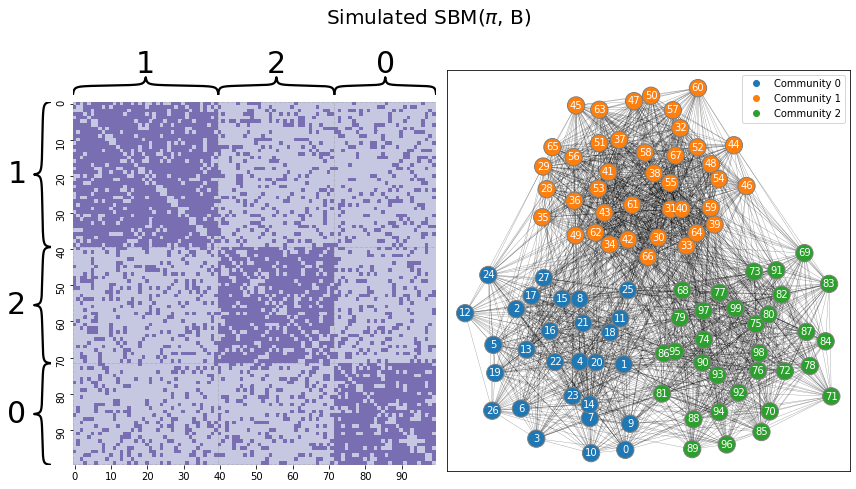

In [77]:
from graspologic.simulations import sbm

pi_vec = [1/3, 1/3, 1/3]
n = 100
# sample counts of each community with probability pi, equivalent to
# sampling a community for each node individually
ns = np.random.multinomial(n, pi_vec, size=1).flatten()

B = [[0.8, 0.2, 0.2],
     [0.2, 0.8, 0.2],
     [0.2, 0.2, 0.8]]

np.random.seed(12)
A = sbm(n=ns, p = B)

# the true community labels
y = [0 for i in range(0,ns[0])] + [1 for i in range(0, ns[1])] + [2 for i in range(0, ns[2])]
draw_multiplot(A, labels=y, xticklabels=10, yticklabels=10, title="Simulated SBM($\pi$, B)");

Remember, however, that we do not *actually* know the community labels of each node in $A$, so this problem is a little more difficult than it might seem. Remember that as we learned in the single network models section, even though the communities eachh node is assigned to *look* obvious, this is an artifact of the ordering of the nodes. In real data, the nodes might not actually be ordered in a manner which makes the community structure as readily apparent.

To proceed, we cannot simply use the `SBMEstimator` class like we did previously. This is because the `SBMEstimator` uses node community assignments, which we do not have. Instead, what we will do is turn again to the adjacency spectral embedding, to reduce the observed network $A$ to a an estimated latent position matrix, $\hat X$. Then, we will use K-Means clustering (or an alternative clustering technique, such as Gaussian Mixture Model) to assign each node's latent position to a particular community. Finally, we will use the communities to which each node is assigned to infer about the block matrix, $B$. We will demonstrate how to use K-means clustering to infer block labels here. We begin by first embedding $A$ to estimate a latent position matrix:

In [78]:
from graspologic.embed import AdjacencySpectralEmbed

ase = AdjacencySpectralEmbed()  # adjacency spectral embedding, with optimal number of latent dimensions selected using elbow picking
Xhat = ase.fit_transform(A)

### Pairs Plots

When embedding a matrix using any embedding techniques of `graspologic`, it is critical to investigate the quality of an embedding. One technique to do so that is particularly useful for uncovering "latent structure" (community assignments which are present, but *unknown* by us ahead of time) from a graph we suspect might be well-fit by a Stochastic Block Model is known as a "pairs plot". In a pairs plot, we investigate how effectively the embedding "separates" nodes within the dataset into individual "clusters". We will ultimately exploit these "clusters" that appear in the latent positions to generate community assignments for each node. To demonstrate the case where the "pairs plot" shows obvious latent community structure, we will use the predicted latent position matrix we just produced, from an adjacency matrix which is a realization of a random network which is truly a Stochastic Block Model. The pairs plot looks like this:

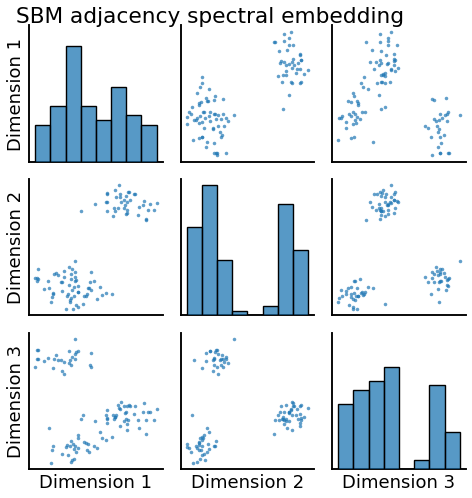

In [79]:
from graspologic.plot import pairplot

_ = pairplot(Xhat, title="SBM adjacency spectral embedding")

As we can see, the pairs plot is a `d x d` matrix of plots, where `d` is the total number of features of the matrix for which a pairs plot is being produced. For each off-diagonal plot (the plots with the dots), the $k^{th}$ row and $l^{th}$ column scatter plot has the points $(x_{ik}, x_{il})$ for each node $i$ in the adjacency matrix. Stated another way, the off-diagonal plot is a scatter plot for each node of the $k^{th}$ dimension and the $l^{th}$ dimension of the latent position matrix. That these scatter plots indicate that the points appear to be separated into individual clusters provides evidence that the latent position matrix contains latent community structure from the realized network, and is a sign that we will find reasonable "guesses" at community assignments further down the line.

The diagonal elements simply represent histograms of the indicated values for the indicated dimension. Higher bars indicate that more points are have weights in that range. For instance, the top-left histogram indicates a histogram of the first latent dimension for all nodes, the middle histogram is a histogram of the second latent dimension for all nodes, so on and so forth.

Next, we will show a brief example of what happens when adjacency spectral embedding does not indicate that there is latent community structure. Our example network here will be a realization of a network which is ER, with a probability of $0.5$ for an edge existing between any pair of nodes. As an ER network does not have community structure, we would not expect the pairs plot to show discernable clusters. 

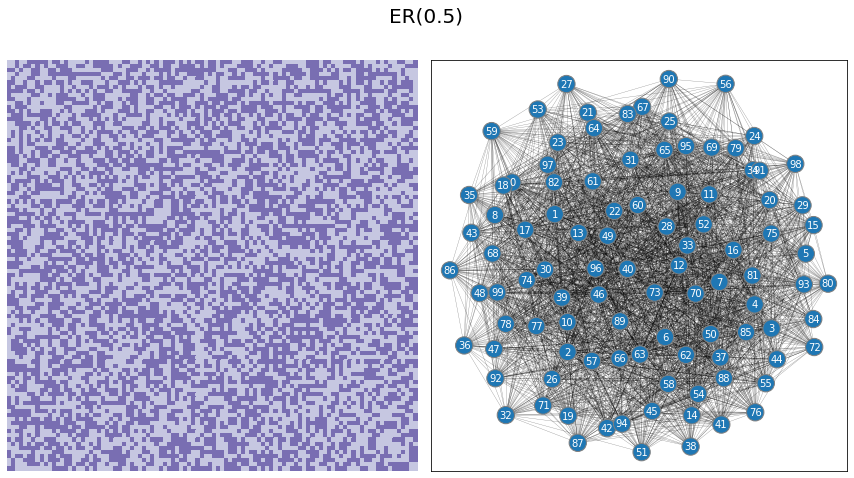

In [80]:
from graspologic.simulations import er_np

A_er = er_np(n=100, p = 0.5)
draw_multiplot(A_er, title="ER(0.5)");

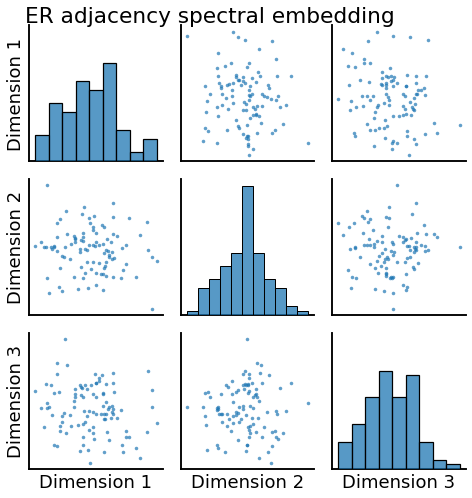

In [81]:
ase_er = AdjacencySpectralEmbed(n_components=3)  # adjacency spectral embedding, with optimal number of latent dimensions selected using elbow picking
Xhat_er = ase_er.fit_transform(A_er)

_ = pairplot(Xhat_er, title="ER adjacency spectral embedding")

Unlike the SBM example, the scatter plots for the adjacency spectral embedding of a realization of an ER network no longer show the distinct separability into individual communities. 

Next, let's return to our SBM example and obtain some predicted community assignments for our points. Since we do not have any information as to which cluster each node is assigned to, we must use an unsupervised clustering method. We will use the `KMeans` function from `sklearn`'s cluster module to do so. Since we know that the SBM has 3 communities, we will use 3 clusters for the KMeans algorithm. The clusters produced by the `KMeans` algorithm will be our "predicted" community assignments.

In [82]:
from sklearn.cluster import KMeans

labels_kmeans = KMeans(n_clusters = 3).fit_predict(Xhat)

Since we have simulated data, we have the benefit of being able to evaluate the quality of our predicted community assignments to the true community assignments. We will use the Adjusted Rand Index (ARI), which is a measure of the clustering accuracy. A high ARI (near $1$) indicates a that the predicted community assignments are good relative the true community assignments, and a low ARI (near $0$) indicates that the predicted community assignments are not good relative the true community assignments. The ARI is agnostic to the names of the different communities, which means that even if the community labels assigned by unsupervised learning do not match the community labels in the true realized network, the ARI is still a legitimate statistic we can investigate. We will look more at the implications of this in the following paragraph.

In [83]:
from sklearn.metrics import adjusted_rand_score

ari_kmeans = adjusted_rand_score(labels_kmeans, y)
print("ARI(predicted communities, true communities) = {}".format(ari_kmeans))

ARI(predicted communities, true communities) = 1.0


The ARI of $1$ indicates that the true communities and the predicted communities are in complete agreement!

When using unsupervised learning to learn about labels (such as, in this case, community assignments) for a given set of points (such as, in this case, the latent positions of each of the $n$ *nodes* of our realized network), a truly unsupervised approach knows *nothing* about the true labels for the set of points. This has the implication that the assigned community labels may not make sense in the context of the true labels, or may not align. For instance, a predicted community of $2$ may not mean the same thing as the true community being $2$, since the true community assignments did not have any *Euclidean* relevance to the set of points we clustered. This means that we may have to remap the labels from the unsupervised learning predictions to better match the true labels so that we can do further diagnostics. For this reason, the `graspologic` package offers the `remap_labels` utility function:

In [84]:
from graspologic.utils import remap_labels

labels_kmeans_remap = remap_labels(y, labels_kmeans)

We can use these remapped labels to understand when `KMeans` is, or is not, producing reasonable labels for our investigation. We begin by first looking at a pairs plot, which now will color the points by their assigned community:

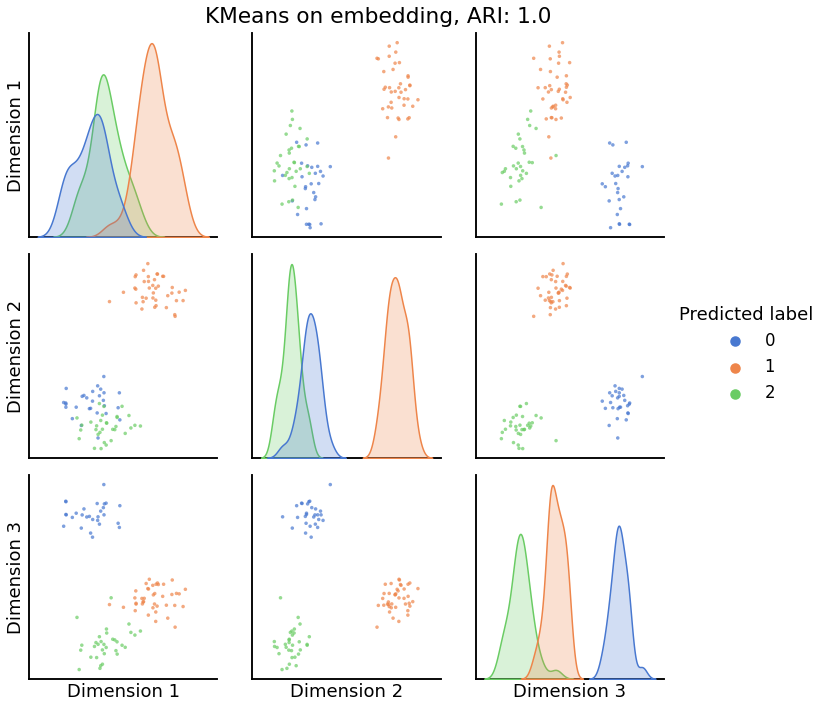

In [85]:
pairplot(Xhat,
         labels=labels_kmeans_remap,
         title=f'KMeans on embedding, ARI: {str(ari_kmeans)[:5]}',
         legend_name='Predicted label',
         height=3.5,
         palette='muted',);

The final utility of the pairs plot is that we can investigate which points, if any, the clustering technique is getting wrong. We can do this by looking at the classification error of the nodes to each community:

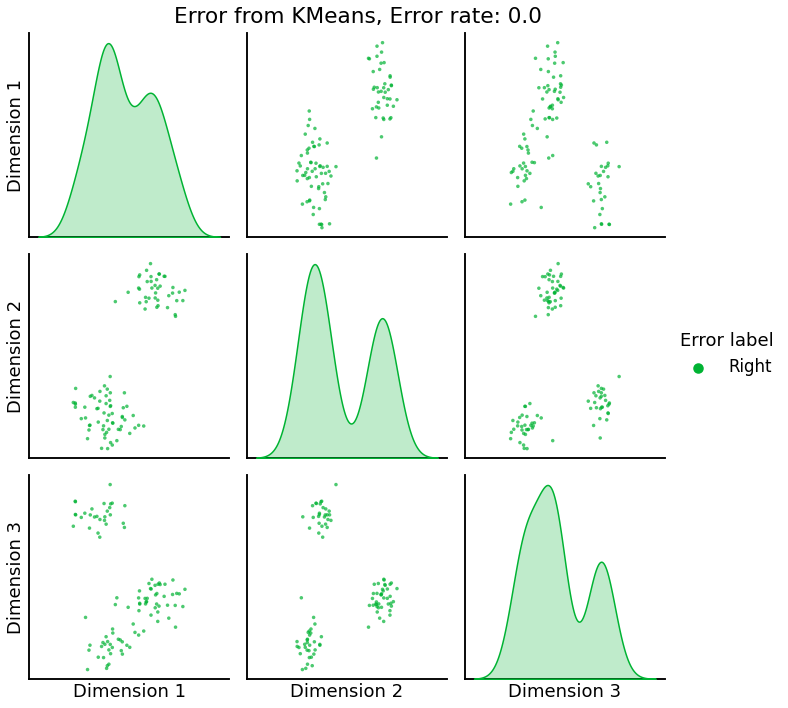

In [86]:
error = y - labels_kmeans_remap  # compute which assigned labels from labels_kmeans_remap differ from the true labels y
error = error != 0  # if the difference between the community labels is non-zero, an error has occurred
er_rt = np.mean(error)  # error rate is the frequency of making an error

palette = {'Right':(0,0.7,0.2),
           'Wrong':(0.8,0.1,0.1)}

error_label = np.array(len(y)*['Right'])  # initialize numpy array for each node
error_label[error] = 'Wrong'  # add label 'Wrong' for each error that is made

pairplot(Xhat,
         labels=error_label,
         title=f'Error from KMeans, Error rate: {str(er_rt)}',
         legend_name='Error label',
         height=3.5,
         palette=palette,);

Great! Our classification has not made any errors.

Next, let's learn about the parameters, $\vec \pi$ and $B$. To learn about $\vec \pi$ is rather simple. Our "best guess" at the probability of a node being assigned to a particular community is simply the fraction of nodes which are assigned to that community by the clustering technique we used:

In [87]:
un, counts = np.unique(labels_kmeans_remap, return_counts=True)
cts = dict(zip(un, counts/np.sum(counts)))
for k, v in cts.items():
    print("pi_{}hat: {}".format(k, v))

pi_0hat: 0.28
pi_1hat: 0.4
pi_2hat: 0.32


So the predicted community assignment probability vector, $\hat{\vec\pi}$, does not exactly match the true community assignment probability vector, $\vec \pi = \begin{bmatrix}\frac{1}{3} & \frac{1}{3} & \frac{1}{3}\end{bmatrix}$. To learn about the block matrix $B$, we can now use the `SBMEstimator` class, with our predicted labels:

In [88]:
from graspologic.models import SBMEstimator

model = SBMEstimator(directed=False, loops=False)
model.fit(A, y=labels_kmeans_remap)
Bhat = model.block_p_

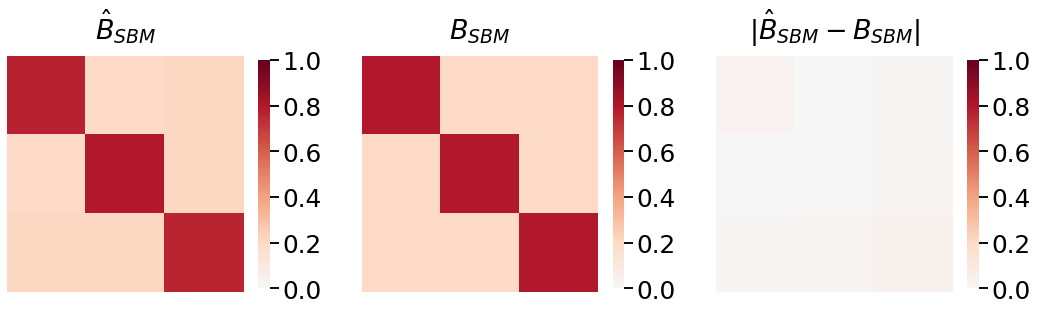

In [89]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

heatmap(Bhat,
        vmin=0,
        vmax=1,
        font_scale=1.5,
        title="$\hat B_{SBM}$",
        ax=axs[0])

heatmap(np.array(B),
        vmin=0,
        vmax=1,
        font_scale=1.5,
        title="$B_{SBM}$",
        ax=axs[1])

heatmap(np.abs(Bhat - np.array(B)),
        vmin=0,
        vmax=1,
        font_scale=1.5,
        title="$|\hat B_{SBM} - B_{SBM}|$",
        ax=axs[2])

fig;

### Number of communities $K$ is not known

In real data, we almost never have the beautiful canonical modular structure obvious to us from a Stochastic Block Model. This means that it is *extremely infrequently* going to be the case that we know exactly how we should set the number of communities, $K$, ahead of time.

Let's first remember back to the single network models section, when we took a Stochastic block model with obvious community structure, and let's see what happens when we just move the nodes of the adjacency matrix around. We begin with a similar adjacency matrix to $A$ given above, for the $3$-community SBM example, but with the within and between-community edge probabilities a bit closer together so that we can see what happens when we experience errors. The communities are still slightly apparent, but less so than before:

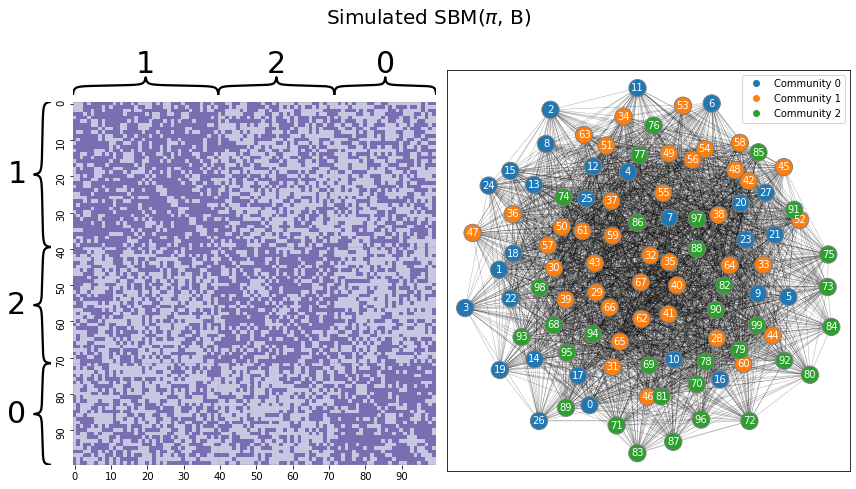

In [106]:
B = [[0.7, 0.45, 0.35],
     [0.45, 0.7, 0.45],
     [0.35, 0.45, 0.7]]
np.random.seed(12)
A = sbm(n=ns, p = B)

# the true community labels
y = [0 for i in range(0,ns[0])] + [1 for i in range(0, ns[1])] + [2 for i in range(0, ns[2])]
draw_multiplot(A, labels=y, xticklabels=10, yticklabels=10, title="Simulated SBM($\pi$, B)");

Next, we permute the nodes around to reorder the realized adjacency matrix:

In [107]:
# generate a reordering of the n nodes
np.random.seed(123)
vtx_perm = np.random.choice(A.shape[0], size=A.shape[0], replace=False)

A_permuted = A[tuple([vtx_perm])] [:,vtx_perm]
y_perm = np.array(y)[vtx_perm]

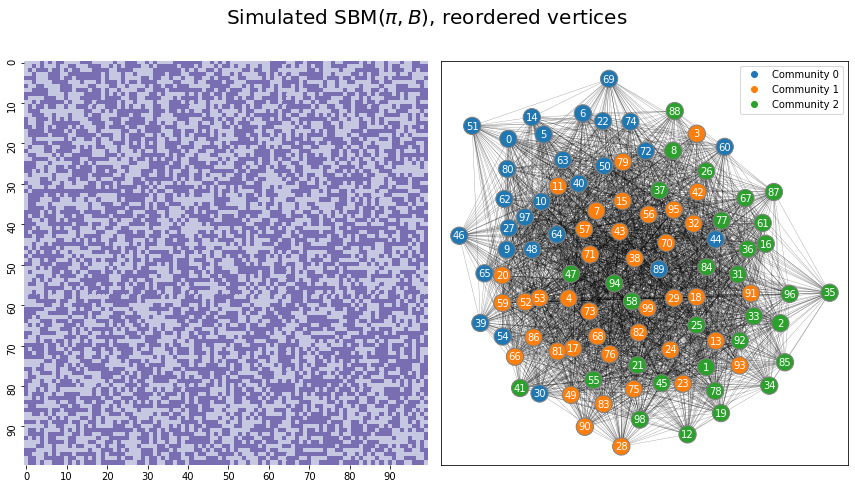

In [108]:
from graphbook_code import heatmap as hm_code 
from graphbook_code import draw_layout_plot as lp_code

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# heatmap
hm = hm_code(
    A_permuted,
    ax=axs[0],
    cbar=False,
    color="sequential",
    xticklabels=10,
    yticklabels=10
)

# layout plot
lp_code(A_permuted, ax=axs[1], pos=None, labels=y_perm, node_color="qualitative")
plt.suptitle("Simulated SBM($\pi, B$), reordered vertices", fontsize=20, y=1.1)
    
fig;

We only get to see the adjacency matrix in the *left* panel; the panel in the *right* is constructed by using the true labels (which we do *not* have!). This means that we proceed for statistical inference about the random network underlying our realized network using *only* the heatmap we have at right. It is not immediately obvious that this is the realization of a random network which is an SBM with $3$ communities.

Our procedure is *very* similar to what we did previously. We again embed using the "elbow picking" technique:

In [109]:
ase_perm = AdjacencySpectralEmbed()  # adjacency spectral embedding, with optimal number of latent dimensions selected using elbow picking
Xhat_permuted = ase_perm.fit_transform(A_permuted)

We examine the pairs plot, *just* like we did previously:

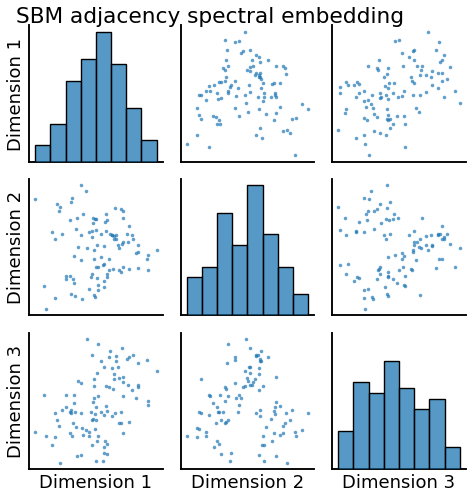

In [110]:
_ = pairplot(Xhat_permuted, title="SBM adjacency spectral embedding")

We can still see that there is some level of latent community structure apparent in the pairs plot. This is evident from, for instance, the plots of Dimension 2 against Dimension 3, where we can see that the latent positions of respective nodes *appear* to be clustering in some way.

Next, we have the biggest difference with the approach we took previously. Since we do *not* know the optimal number of clusters $K$ *nor* the true community assignments, we must choose an unsupervised clustering technique which allows us to *compare* clusterings with different choices of clusters. We can again perform this using the `KMeans` algorithm that we used previously. Here, we will compare the quality of a clustering with one number of clusters to the quality of a clustering with a *different* number of clusters using the silhouette score. The optimal clustering is selected to be the clustering which has the largest silhouette score across all attempted numbers of clusters.

This feature is implemented automatically in the `KMeansCluster` function of `graspologic`. We will select the number of clusters which maximizes the silhouette score, and will allow at most $10$ clusters total to be produced:

In [111]:
from graspologic.cluster import KMeansCluster

km_clust = KMeansCluster(max_clusters = 10)
km_clust = km_clust.fit(Xhat_permuted);

Next, we visualize the silhouette score as a function of the number of clusters:

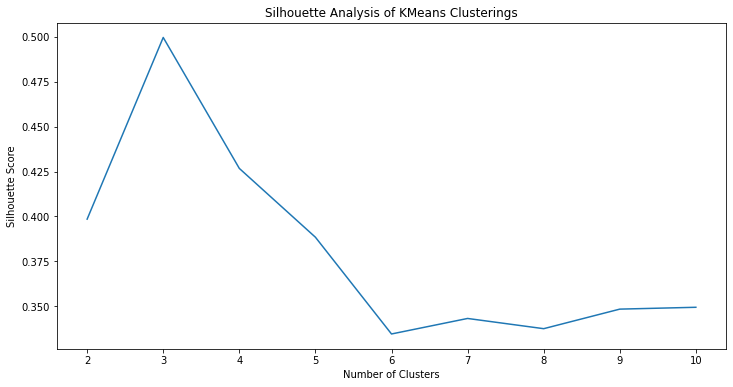

In [112]:
import seaborn as sns
from pandas import DataFrame as df

nclusters = range(2, 11)  # graspologic nclusters goes from 2 to max_clusters
silhouette = km_clust.silhouette_  # obtain the respective silhouette scores

silhouette_df = df({"Number of Clusters": nclusters, "Silhouette Score": silhouette})  # place into pandas dataframe

fig, ax = plt.subplots(1,1,figsize=(12, 6))

sns.lineplot(data=silhouette_df,ax=ax, x="Number of Clusters", y="Silhouette Score");
ax.set_title("Silhouette Analysis of KMeans Clusterings")
fig;

As we can see, Silhouette Analysis has indicated the best number of clusters as $3$ (which, is indeed, *correct* since we are performing a simulation where we know the right answer). Next, let's take a look at the pairs plot for the optimal classifier. We begin by producing the predicted labels for each of our nodes, and remapping to the true community assignment labels, exactly as we did previously for further analysis:

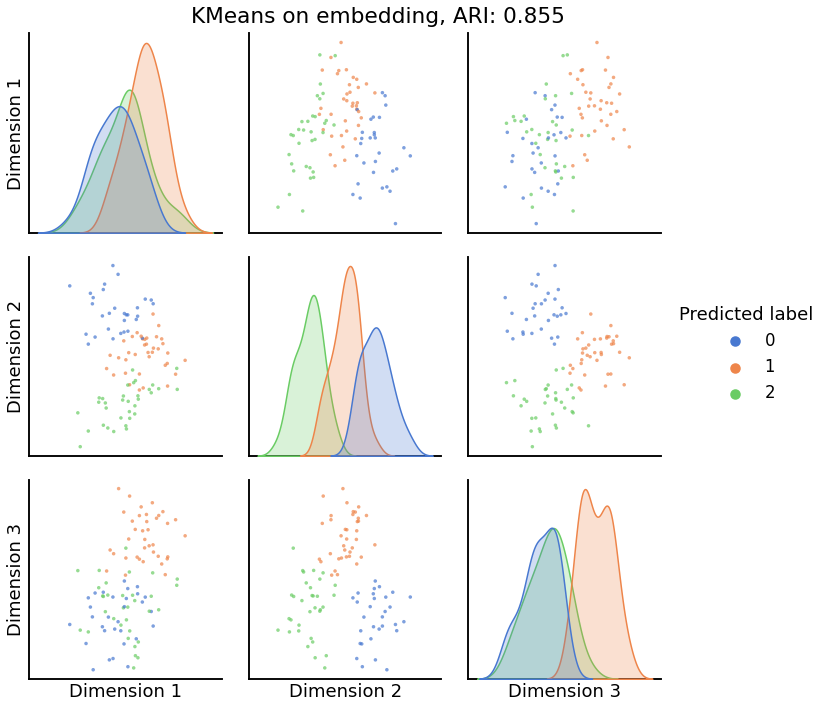

In [113]:
labels_autokmeans = km_clust.fit_predict(Xhat_permuted)
labels_autokmeans = remap_labels(y_perm, labels_autokmeans)

ari_kmeans = adjusted_rand_score(labels_autokmeans, y_perm)

pairplot(Xhat_permuted,
         labels=labels_autokmeans,
         title=f'KMeans on embedding, ARI: {str(ari_kmeans)[:5]}',
         legend_name='Predicted label',
         height=3.5,
         palette='muted',);

`KMeans` was still able to find relatively stable clusters, which align quite well (ARI of $0.855$, which is not perfect but closer to $1$ than to $0$!) with the true labels! Next, we will look at which points `KMeans` tends to get *wrong* to see if any patterns arise:

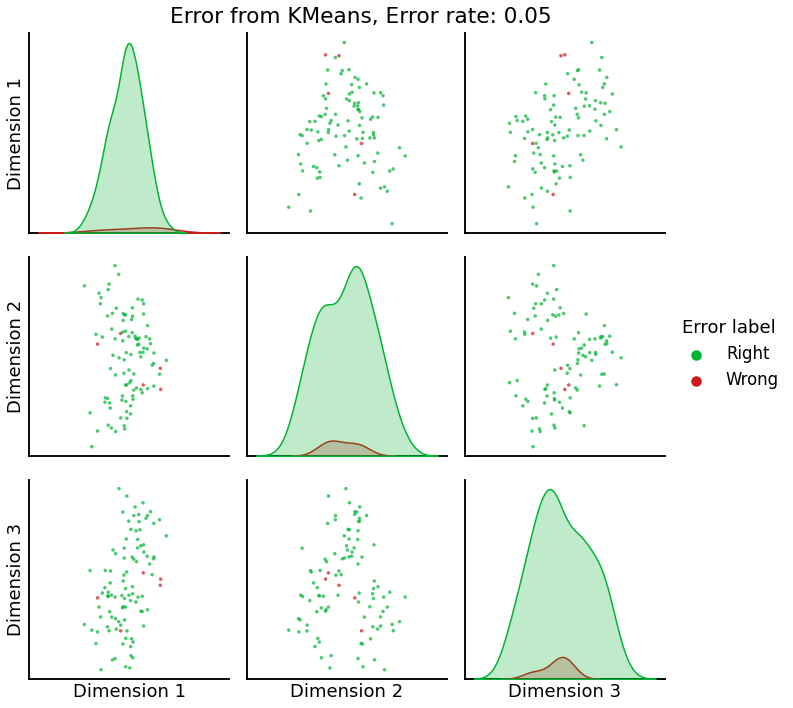

In [115]:
error = y_perm - labels_autokmeans  # compute which assigned labels from labels_kmeans_remap differ from the true labels y
error = error != 0  # if the difference between the community labels is non-zero, an error has occurred
er_rt = np.mean(error)  # error rate is the frequency of making an error

palette = {'Right':(0,0.7,0.2),
           'Wrong':(0.8,0.1,0.1)}

error_label = np.array(len(y)*['Right'])  # initialize numpy array for each node
error_label[error] = 'Wrong'  # add label 'Wrong' for each error that is made

pairplot(Xhat_permuted,
         labels=error_label,
         title=f'Error from KMeans, Error rate: {str(er_rt)}',
         legend_name='Error label',
         height=3.5,
         palette=palette,);

And there do not appear to be any dramatic issues in our clustering which woul suggest systematic errors are present. To infer about $\vec \pi$ or $B$, we would proceed exactly as we did previously, by using these labels with the `SBMEstimator` class to perform inference:

In [116]:
un, counts = np.unique(labels_autokmeans, return_counts=True)
cts = dict(zip(un, counts/np.sum(counts)))
for k, v in cts.items():
    print("pi_{}hat: {}".format(k, v))

pi_0hat: 0.3
pi_1hat: 0.37
pi_2hat: 0.33


In [117]:
model = SBMEstimator(directed=False, loops=False)
model.fit(A_permuted, y=labels_autokmeans)
Bhat = model.block_p_

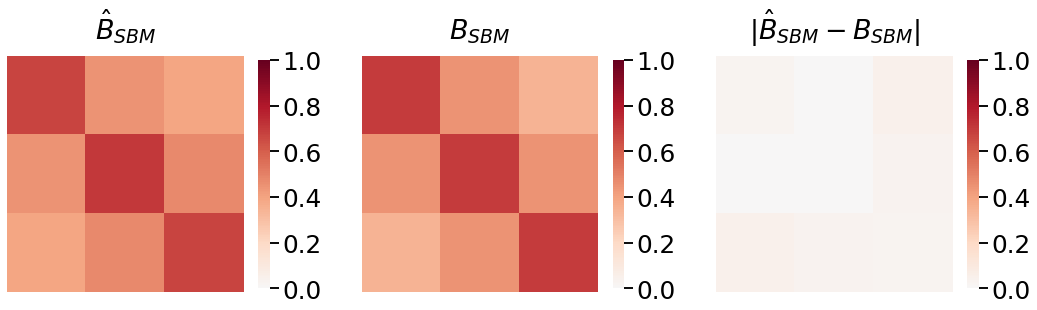

In [118]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

heatmap(Bhat,
        vmin=0,
        vmax=1,
        font_scale=1.5,
        title="$\hat B_{SBM}$",
        ax=axs[0])

heatmap(np.array(B),
        vmin=0,
        vmax=1,
        font_scale=1.5,
        title="$B_{SBM}$",
        ax=axs[1])

heatmap(np.abs(Bhat - np.array(B)),
        vmin=0,
        vmax=1,
        font_scale=1.5,
        title="$|\hat B_{SBM} - B_{SBM}|$",
        ax=axs[2])

fig;

Which appears very close to the true $B$.

```{admonition} a posteriori Stochastic Block Model, Recap
We just covered many details about how to perform statistical inference with a realization of a random network which we think can be well summarized by a Stochastic Block Model. For this reason, we will review some of the key things that were covered, to better put them in context:
1. We learned that the Adjacency Spectral Embedding is a key algorithm for making sense of networks we believe may be realizations of networks which are well-summarized by Stochastic Block Models, as inference on the the *estimated latent positions* is key for learning about community assignments.
2. We learned how unsupervised learning allows us to use the estimated latent positions to learn community assignments for nodes within our realization.
3. We learned how to *align* the labels produced by our unsupervised learning technique with true labels in our network, using `remap_labels`.
4. We learned how to produce community assignments, regardless of whether we know how many communities may be present in the first place.
```